# Explore Importance of Features in Random Forests

## Algorithmic Methods & Machine Learning

### Walter Genchi
<a href="mailto:walter.genchi@studenti.unipd.it">walter.genchi@studenti.unipd.it</a><br/>

June, 14 2018

## Packages & Files
- Let's first import all the packages that we will need.


- Now import the **.csv** datasets:
  * [winequality-red.csv](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/data), related to red variants of the Portuguese "Vinho Verde" wine.
    
  * [kc_house_data.csv](https://www.kaggle.com/harlfoxem/housesalesprediction/data), related to house sale prices for King County.


- We also import some specific **.py** files:
   * [boruta_py.py](https://github.com/scikit-learn-contrib/boruta_py) is the Python implementation of the Boruta R package.
   * [rfpimp.py](https://github.com/parrt/random-forest-importances) is the Python implementation of Permutation Importance.

In [1]:
#Importing required packages.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.metrics import r2_score

import sys

sys.path.insert(0, 'boruta_py-master/boruta')
import boruta_py

sys.path.insert(0, 'random-forest-importances-master/src')
from rfpimp import *

%matplotlib inline

In [2]:
wine = pd.read_csv('winequality-red.csv')

In [3]:
house = pd.read_csv("kc_house_data.csv")

## Outline
### Feature Importance for Tree Models
* Gini Importance  
* Permutation Importance
* Boruta

### Experimental Results for Wine Dataset
* Exploratory Data Analysis (EDA)
* Model Fitting and Prediction Performances 
* Feature Importance
* Feature Selection and new Prediction Performances

### Experimental Results for House Sales Dataset
* Exploratory Data Analysis (EDA)
* Model Fitting and Prediction Performances 
* Feature Importance
* Feature Selection and new Prediction Performances

# 1 - Feature Importance for Tree Models

Random forests are among the most popular machine learning methods thanks to their relatively good accuracy, robustness and ease of use. They also provide two straightforward methods for feature selection:
- **Gini Importance** or Mean Decrease in Impurity (**MDI**)
- **Permutation Importance** or Mean Decrease in Accuracy (**MDA**)

A novel all-relevant feature selection method is:
- [**Boruta**](https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf), conceived by Witold R. Rudnicki and developed by Miron B. Kursa at the Interdisciplinary Centre for Mathematical and Computational Modelling at the University of Warsaw (ICM UW)

## 1.1 - Gini Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set.

The measure based on which the (locally) optimal condition is chosen is called **impurity**.
- For classification trees, it is typically either **Gini impurity** or **information gain/entropy**
- For regression trees, it is **variance**

### Algorithm

When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree:
- Every time a split of a node is made on variable *j* **the Gini impurity criterion** (or information entropy) **for the two descendent nodes is less than the parent node**.
- **Adding up the Gini decreases for each individual variable over all trees** in the forest gives a fast variable importance that is often very consistent with the permutation importance measure.

### Remarks

There are a few things to keep in mind when using the impurity based ranking.

- Firstly, feature selection based on impurity reduction is **biased towards preferring variables with more categories** (see [Bias in random forest variable importance measures](https://link.springer.com/article/10.1186%2F1471-2105-8-25)).

- Secondly, when the dataset has **two (or more) correlated features**, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, **the importance of others is significantly reduced** since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

In the following example, we have three correlated variables $X_{0}$, $X_{1}$, $X_{2}$ and no noise in the data, with the output variable $Y$ simply being the sum of the three features:

In [4]:
size = 10000
np.random.seed(seed=10)
X_seed = np.random.normal(0, 1, size)
X0 = X_seed + np.random.normal(0, .1, size)
X1 = X_seed + np.random.normal(0, .1, size)
X2 = X_seed + np.random.normal(0, .1, size)
X = np.array([X0, X1, X2]).T
Y = X0 + X1 + X2
  
rf = RandomForestRegressor(n_estimators=20, max_features=2)
rf.fit(X, Y);
print("Scores for X0, X1, X2: {}".format(rf.feature_importances_))

Scores for X0, X1, X2: [ 0.27236571  0.54836524  0.17926905]


When we compute the feature importances, we see that $X_{1}$ is computed to have over 10x higher importance than $X_{2}$, while their “true” importance is very similar. This happens despite the fact that the data is noiseless, we use 20 trees, random selection of features (at each split, only two of the three features are considered) and a sufficiently large dataset.

One thing to point out though is that the difficulty of interpreting the importance/ranking of correlated variables is not random forest specific, but applies to most model based feature selection methods. The effect of this phenomenon is somewhat reduced thanks to **random selection of features at each node creation**, but in general the effect is not removed completely.

### Implementation

In scikit-learn Gini Importance is implemented as **`RandomForestClassifier.feature_importances_`** for classification or **`RandomForestRegressor.feature_importances_`** for regression problems.

## 1.2 - Permutation Importance

Random forests also use the OOB samples to construct a different variable-importance measure, apparently to measure the prediction strength of each variable.

### Algorithm

- When the *b*-th tree is grown, the **OOB samples are passed down** the tree, and the prediction accuracy is recorded.
- Then the values for the *j*-th variable are **randomly permuted in the OOB samples**, and the accuracy is again computed. 
- The **decrease in accuracy** as a result of this permuting is **averaged over all trees**, and is used as a measure of the importance of variable *j* in the random forest.

For other tree models without bagging mechanism, hence **without OOB samples**, we can create a **separate validation set** (apart from the test set) and use it to evaluate the decrease in accuracy.

### Remarks

It has been shown (see [Conditional variable importance for random forests](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)) that permutation importance **over-estimates the importance of correlated predictor variables**, due to a preference for the selection of correlated predictors in the tree building process.

### Implementation

This method is not directly exposed in scikit-learn, but it is straightforward to implement it in Python:

In [5]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    std = []
    for col in X_train.columns:
        tmp=[]
        for i in range(10):
            save = X_train[col].copy()
            X_train[col] = np.random.permutation(X_train[col])
            m = metric(rf, X_train, y_train)
            X_train[col] = save
            tmp.append(m)
        imp.append(baseline - np.mean(tmp))
        std.append(np.std(tmp))
    return np.array(imp),np.array(std)

Notice that the function does not normalize the importance values, such as dividing by the standard deviation.

However, for each column, we repeat the permutation 10 times, in order to have a **more robust estimate** of the Mean Decrease in Accuracy (MDA) and also to compute the **standard deviation** of such estimate.

Note that **`metric`** has two possible inputs:
- `oob_classifier_accuracy`, which computes the out-of-bag (OOB) Accuracy for a scikit-learn random forest
    classifier.
- `oob_regression_r2_score`, which computes out-of-bag (OOB) $R^2$ for a scikit-learn random forest
    regressor.

These functions are implemented in `rfpimp.py`.

The use of OOB samples for permutation importance computation has strongly negative performance implications. Using OOB samples means iterating through the trees with a **Python loop** rather than using the highly vectorized code inside scikit/numpy for making predictions.

## 1.3 - Boruta

Boruta is the name of an R package that implements a novel feature selection algorithm. It randomly permutes variables like Permutation Importance does, but performs **permutation on all variables at the same time** and concatenates the shuffled features with the original ones. It iteratively removes the features which are **proved by a statistical test to be less relevant than random probes**.

### Algorithm

- First, we duplicate our dataset, and shuffle the values in each column, these are called **shadow features**.
- Then, we **train a classifier on the new merged dataset**, such that we get importances for each of our features.
- Now, we **check** for each of our real features **if they have higher importance** than the best of the shadow features.
- If they do, we record this in a vector (these are called a **hits**) and continue with another iteration.
- At every iteration we **perform a statistical test** checking if a given feature is doing better then expected than random chance. We do this by simply comparing the number of times a feature did better than the shadow features using a binomial distribution.
- Features which are confidently better than shadow features are marked **“confirmed”**, while those which are not are marked **“rejected”** and **removed from the original data matrix**.
- After a set number of iterations (or if all the features have been either confirmed or rejected) we stop.

<img src="images/boruta.png", style="width:400px;height:300px;">

### Remarks

When the statistical test is performed, as we do this for thousands of features, we need to correct for multiple testing. The original method uses the rather conservative **Bonferroni** correction for this. In the Python implementation, the correction for multiple testing was relaxed by making it a **two step process**, rather than a harsh one step Bonferroni correction.

Although Boruta is a feature selection algorithm, we can use the order of confirmation/rejection as a way to **rank the importance of features**.

### Implementation

The implementation in Python is based on the functions available in the `boruta_py.py` file.

# 2 - Experimental Results for Wine Dataset

### Wine Dataset

The first dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

Input continuous variables (based on physicochemical tests):
- fixed acidity 
- volatile acidity 
- citric acid 
- residual sugar 
- chlorides 
- free sulfur dioxide
- total sulfur dioxide
- density
- pH 10
- sulphates
- alcohol

Output categorical variable (based on sensory data):
- quality (score between 0 and 10)

## 2.1 - Exploratory Data Analysis (EDA)

### Split the problem into a binary task

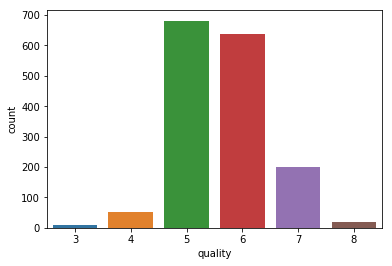

In [6]:
#count of the target variable
sns.countplot(x='quality', data=wine)

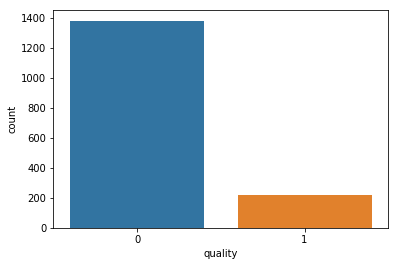

In [7]:
# Making binary classification for the response variable.
# Dividing wine as good and bad by giving the limit for the quality
# bad: quality <= 6
# good: quality >= 7
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)
#Now lets assign a labels to our quality variable
label_quality = LabelEncoder()
#bad becomes 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])
# new response variable
sns.countplot(x='quality', data=wine)

### Relationhips between quality and features

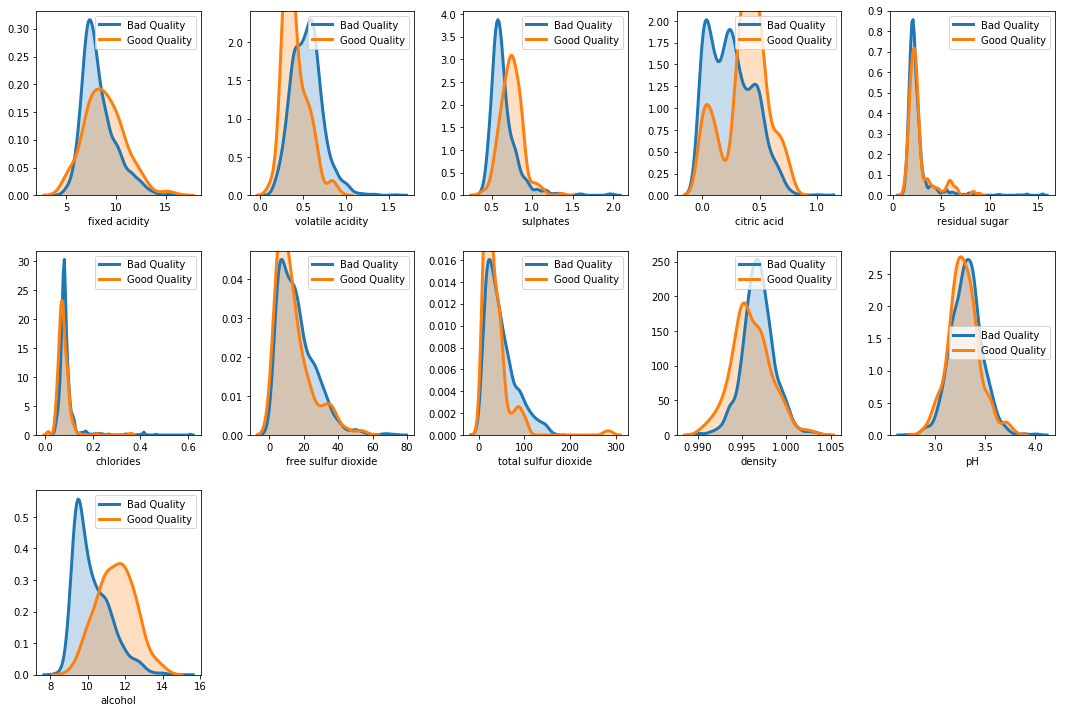

In [8]:
fig, ax =plt.subplots(nrows=3,ncols=5,figsize=(15,10))

sns.distplot(wine[wine['quality']==0]['fixed acidity'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[0][0])
sns.distplot(wine[wine['quality']==1]['fixed acidity'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[0][0])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['volatile acidity'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[0][1])
sns.distplot(wine[wine['quality']==1]['volatile acidity'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[0][1])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['sulphates'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[0][2])
sns.distplot(wine[wine['quality']==1]['sulphates'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[0][2])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['citric acid'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[0][3])
sns.distplot(wine[wine['quality']==1]['citric acid'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[0][3])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['residual sugar'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[0][4])
sns.distplot(wine[wine['quality']==1]['residual sugar'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[0][4])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['chlorides'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[1][0])
sns.distplot(wine[wine['quality']==1]['chlorides'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[1][0])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['free sulfur dioxide'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[1][1])
sns.distplot(wine[wine['quality']==1]['free sulfur dioxide'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[1][1])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['total sulfur dioxide'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[1][2])
sns.distplot(wine[wine['quality']==1]['total sulfur dioxide'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[1][2])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['density'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[1][3])
sns.distplot(wine[wine['quality']==1]['density'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[1][3])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['pH'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[1][4])
sns.distplot(wine[wine['quality']==1]['pH'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[1][4])
#plt.legend(loc=0, prop={'size': 8})

sns.distplot(wine[wine['quality']==0]['alcohol'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Bad Quality',ax=ax[2][0])
sns.distplot(wine[wine['quality']==1]['alcohol'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Good Quality',ax=ax[2][0])
#plt.legend(loc=0, prop={'size': 8})

fig.tight_layout()
plt.subplots_adjust(wspace=.3, hspace=.3)

fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
fig.delaxes(ax[2][3])
fig.delaxes(ax[2][4])
# Plot formatting

#.xlabel('Fixed Acidity')
#fig.ylabel('Density')

The features that best "explain" wine quality seem **alcohol**, **sulphates**, **volatile acidity** and **citric acid**.

### Correlation between features

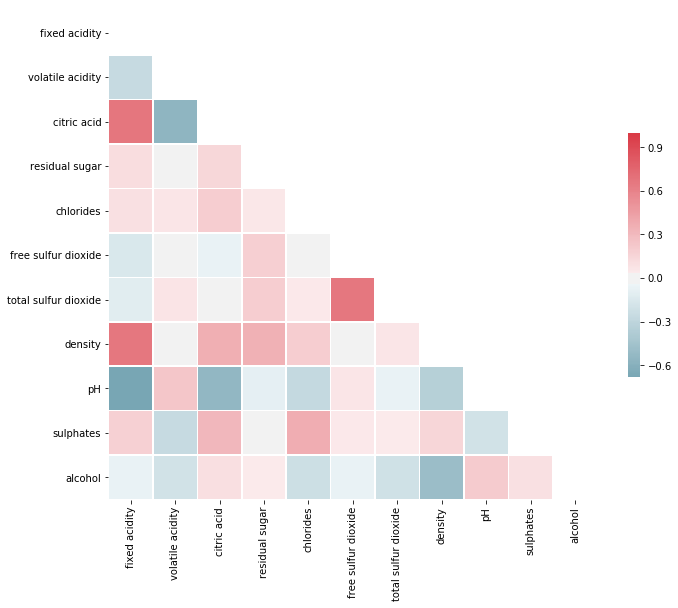

In [9]:
corr = wine.drop('quality',axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Features are not highly correlated between each other (i.e. no risk of multicollinearity).

**Positively correlated**:
- "total sulfur dioxide" with "free sulfur dioxide"
- "fixed acidity" with "citric acid" 
- "fixed acidity" with "density" 

**Negatively correlated**:
- "pH" with "fixed acidity"
- "pH" with "citric acid"
- "citric acid" with "volatile acidity"

The correlations are probably due to the physical relationships between the features.

## 2.2 - Model Fitting and Prediction Performances

### Split into Training set and Test set 

In [10]:
#Now seperate the dataset as response variable and feature variabes
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [11]:
df_train, df_test = train_test_split(wine, test_size=0.20,random_state=42)
df_train = df_train[list(wine.columns)]
df_test = df_test[list(wine.columns)]

In [12]:
X_train, y_train = df_train.drop('quality',axis=1), df_train['quality']
X_test, y_test = df_test.drop('quality',axis=1), df_test['quality']

In [13]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1279, 11), (1279,), (320, 11), (320,))

### Model Fitting

In [14]:
rf = RandomForestClassifier(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

### Prediction Performances

In [15]:
#Let's see how our model performed
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      0.98      0.93       273
          1       0.68      0.28      0.39        47

avg / total       0.86      0.88      0.85       320



## 2.3 - Feature Importance

### Gini Importance

The attribute **`feature_importances_`** used here for Gini Importance is already implemented in scikit-learn.

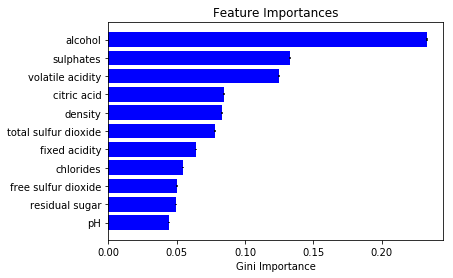

In [16]:
features = np.array(X_train.columns)
imps_gini=rf.feature_importances_
std_gini = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices_gini = np.argsort(imps_gini)

plt.title('Feature Importances')
plt.barh(range(len(indices_gini)), imps_gini[indices_gini], yerr=std_gini[indices_gini],color='b', align='center')
plt.yticks(range(len(indices_gini)), features[indices_gini])
plt.xlabel('Gini Importance')
plt.show()

### Permutation Importance

The function **`permutation_importances`** used here for Permutation Importance was defined above.

In [18]:
np.random.seed(10)
imps_perm, std_perm = permutation_importances(rf, X_train, y_train,
                              oob_classifier_accuracy)

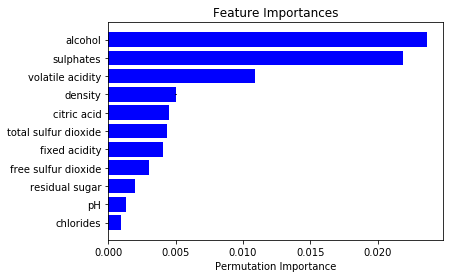

In [19]:
features = np.array(X_train.columns)
indices_perm = np.argsort(imps_perm)

plt.title('Feature Importances')
plt.barh(range(len(indices_perm)), imps_perm[indices_perm], yerr=std_perm[indices_perm],color='b', align='center')
plt.yticks(range(len(indices_perm)), features[indices_perm])
plt.xlabel('Permutation Importance')
plt.show()

The Permutation Importance method, compared to the Gini Importance method:
- Amplifies the spread of **alcohol** and **sulphates** with respect to the other features. This could be due also to the fact that Permutation Importance over-estimates the importance of correlated predictor variables (the correlation between alcohol and sulphates is 0.09). 
- Decreases the rank of importance of **chlorides**.  

### Boruta

The function **`BorutaPy`** used here for Boruta was describe above and is part of the **`boruta_py`** Github repository.

In [20]:
forest = RandomForestClassifier(n_estimators=200,
                                min_samples_leaf=5,
                                n_jobs=-1,
                                oob_score=True,
                                random_state=42)
feat_selector = boruta_py.BorutaPy(forest, verbose=2,max_iter=100)

In [21]:
np.random.seed(10)

import time

start = time.time()

feat_selector.fit(X_train.values, y_train.values)

end = time.time()

print(end - start)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration:

After fitting BorutaPy, it provides the user with **ranking of features**.
- Confirmed ones are 1
- Tentatives are 2
- Rejected are ranked starting from 3, based on their feature importance history through the iterations.

In [22]:
print('Confirmed: \n',list(np.array(X_train.columns)[feat_selector.ranking_==1]))
print('\nTentatives: \n',list(np.array(X_train.columns)[feat_selector.ranking_==2]))
print('\nRejected: \n',list(np.array(X_train.columns)[feat_selector.ranking_>=3]))

Confirmed: 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']

Tentatives: 
 ['free sulfur dioxide']

Rejected: 
 ['pH']


Some remarks:
- The Boruta procedure takes around 5 minutes to reach 100 iterations.
- At the end of the 100 iterations only variable **pH** is rejected
- Variable **free sulfur dioxide** is still in Tentatives (more iterations would be required)

## 2.4 - Feature Selection and Prediction Performances

### Feature Selection based on Gini Importance 

Variables with a **Gini Importance score lower than a treshold (e.g. 0.05)** are excluded from the new Random Forest model, i.e. varibales **pH**, **residual sugar** and **free sulfur dioxide**. 

In [23]:
X_train_gini=X_train.drop(['pH','residual sugar','free sulfur dioxide'],axis=1)
X_test_gini=X_test.drop(['pH','residual sugar','free sulfur dioxide'],axis=1)

In [24]:
rf_gini = RandomForestClassifier(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_gini.fit(X_train_gini, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

### Feature Selection based on Permutation Importance

Variables with a **Permutation Importance score lower than a treshold (e.g. 0.003)** are excluded from the new Random Forest model, i.e. varibales **chlorides**, **pH** and **residual sugar**. 

In [25]:
X_train_perm=X_train.drop(['chlorides','pH','residual sugar'],axis=1)
X_test_perm=X_test.drop(['chlorides','pH','residual sugar'],axis=1)

In [26]:
rf_perm = RandomForestClassifier(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_perm.fit(X_train_perm, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

### Feature Selection based on Boruta

Variables that have been **rejected** in the Boruta Importance procedure are excluded from the new Random Forest model, i.e. variable **pH**.

In [27]:
X_train_boruta=X_train.drop(['pH'],axis=1)
X_test_boruta=X_test.drop(['pH'],axis=1)

In [28]:
rf_boruta = RandomForestClassifier(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_boruta.fit(X_train_boruta, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

### Prediction Performances

In [29]:
print('******************* Original Model ***********************')
print('\n')
print(classification_report(y_test, rf.predict(X_test)))

print ('\n')

print('**** Feature selection based on Gini Importance ****')
print('\n')
print(classification_report(y_test, rf_gini.predict(X_test_gini)))

print ('\n')

print('**** Feature selection based on Permutation Importance *****')
print('\n')
print(classification_report(y_test, rf_perm.predict(X_test_perm)))

print ('\n')

print('*********** Feature selection based on Boruta **************')
print('\n')
print(classification_report(y_test, rf_boruta.predict(X_test_boruta)))

******************* Original Model ***********************


             precision    recall  f1-score   support

          0       0.89      0.98      0.93       273
          1       0.68      0.28      0.39        47

avg / total       0.86      0.88      0.85       320



**** Feature selection based on Gini Importance ****


             precision    recall  f1-score   support

          0       0.89      0.98      0.94       273
          1       0.75      0.32      0.45        47

avg / total       0.87      0.88      0.86       320



**** Feature selection based on Permutation Importance *****


             precision    recall  f1-score   support

          0       0.90      0.98      0.94       273
          1       0.76      0.34      0.47        47

avg / total       0.88      0.89      0.87       320



*********** Feature selection based on Boruta **************


             precision    recall  f1-score   support

          0       0.89      0.98      0.93       273


Some remarks:
- **Permuation Importance feature selection** provides the **best model** in terms of precision, recall and f1-score.
- Varibale **chlorides**, which is not removed in the model based on the Gini Importance, seems to worse prediction performances.
- It should be noted that variable **chlorides** is the **"worst" feature** in the Permutation Importance scheme.
- Removing only variable **pH** (i.e. Boruta feature selection) does not make an effect on the precidiction performances.

# 3 - Experimental Results for House Sales Dataset

### House Sales Dataset

The second dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

Input continuous variables:
- id
- date
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- waterfront
- view
- condition
- grade
- sqft_above
- sqft_basement
- yr_built
- yr_renovated
- zipcode
- lat
- long
- sqft_living15
- sqft_lot15

Output continuous variable:
- price

## 3.1 - Exploratory Data Analysis (EDA)

### Data Preparation

In [30]:
# Looking for nulls
print(house.isnull().any())
# Inspecting type
print(house.dtypes)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_

In [31]:
# Dropping the id and date columns, as these 2 features will not be used in this analysis.
house = house.drop(['id', 'date'],axis=1)

### Pairplots

It is convenient to visualize the target variable **price ** together with the features 
- **sqft_lot**, the square footage of the lot
- **sqft_above**, the square footage of house apart from basement
- **sqft_living**, the square footage of the home
- **bedrooms**, the number of bedrooms in the house

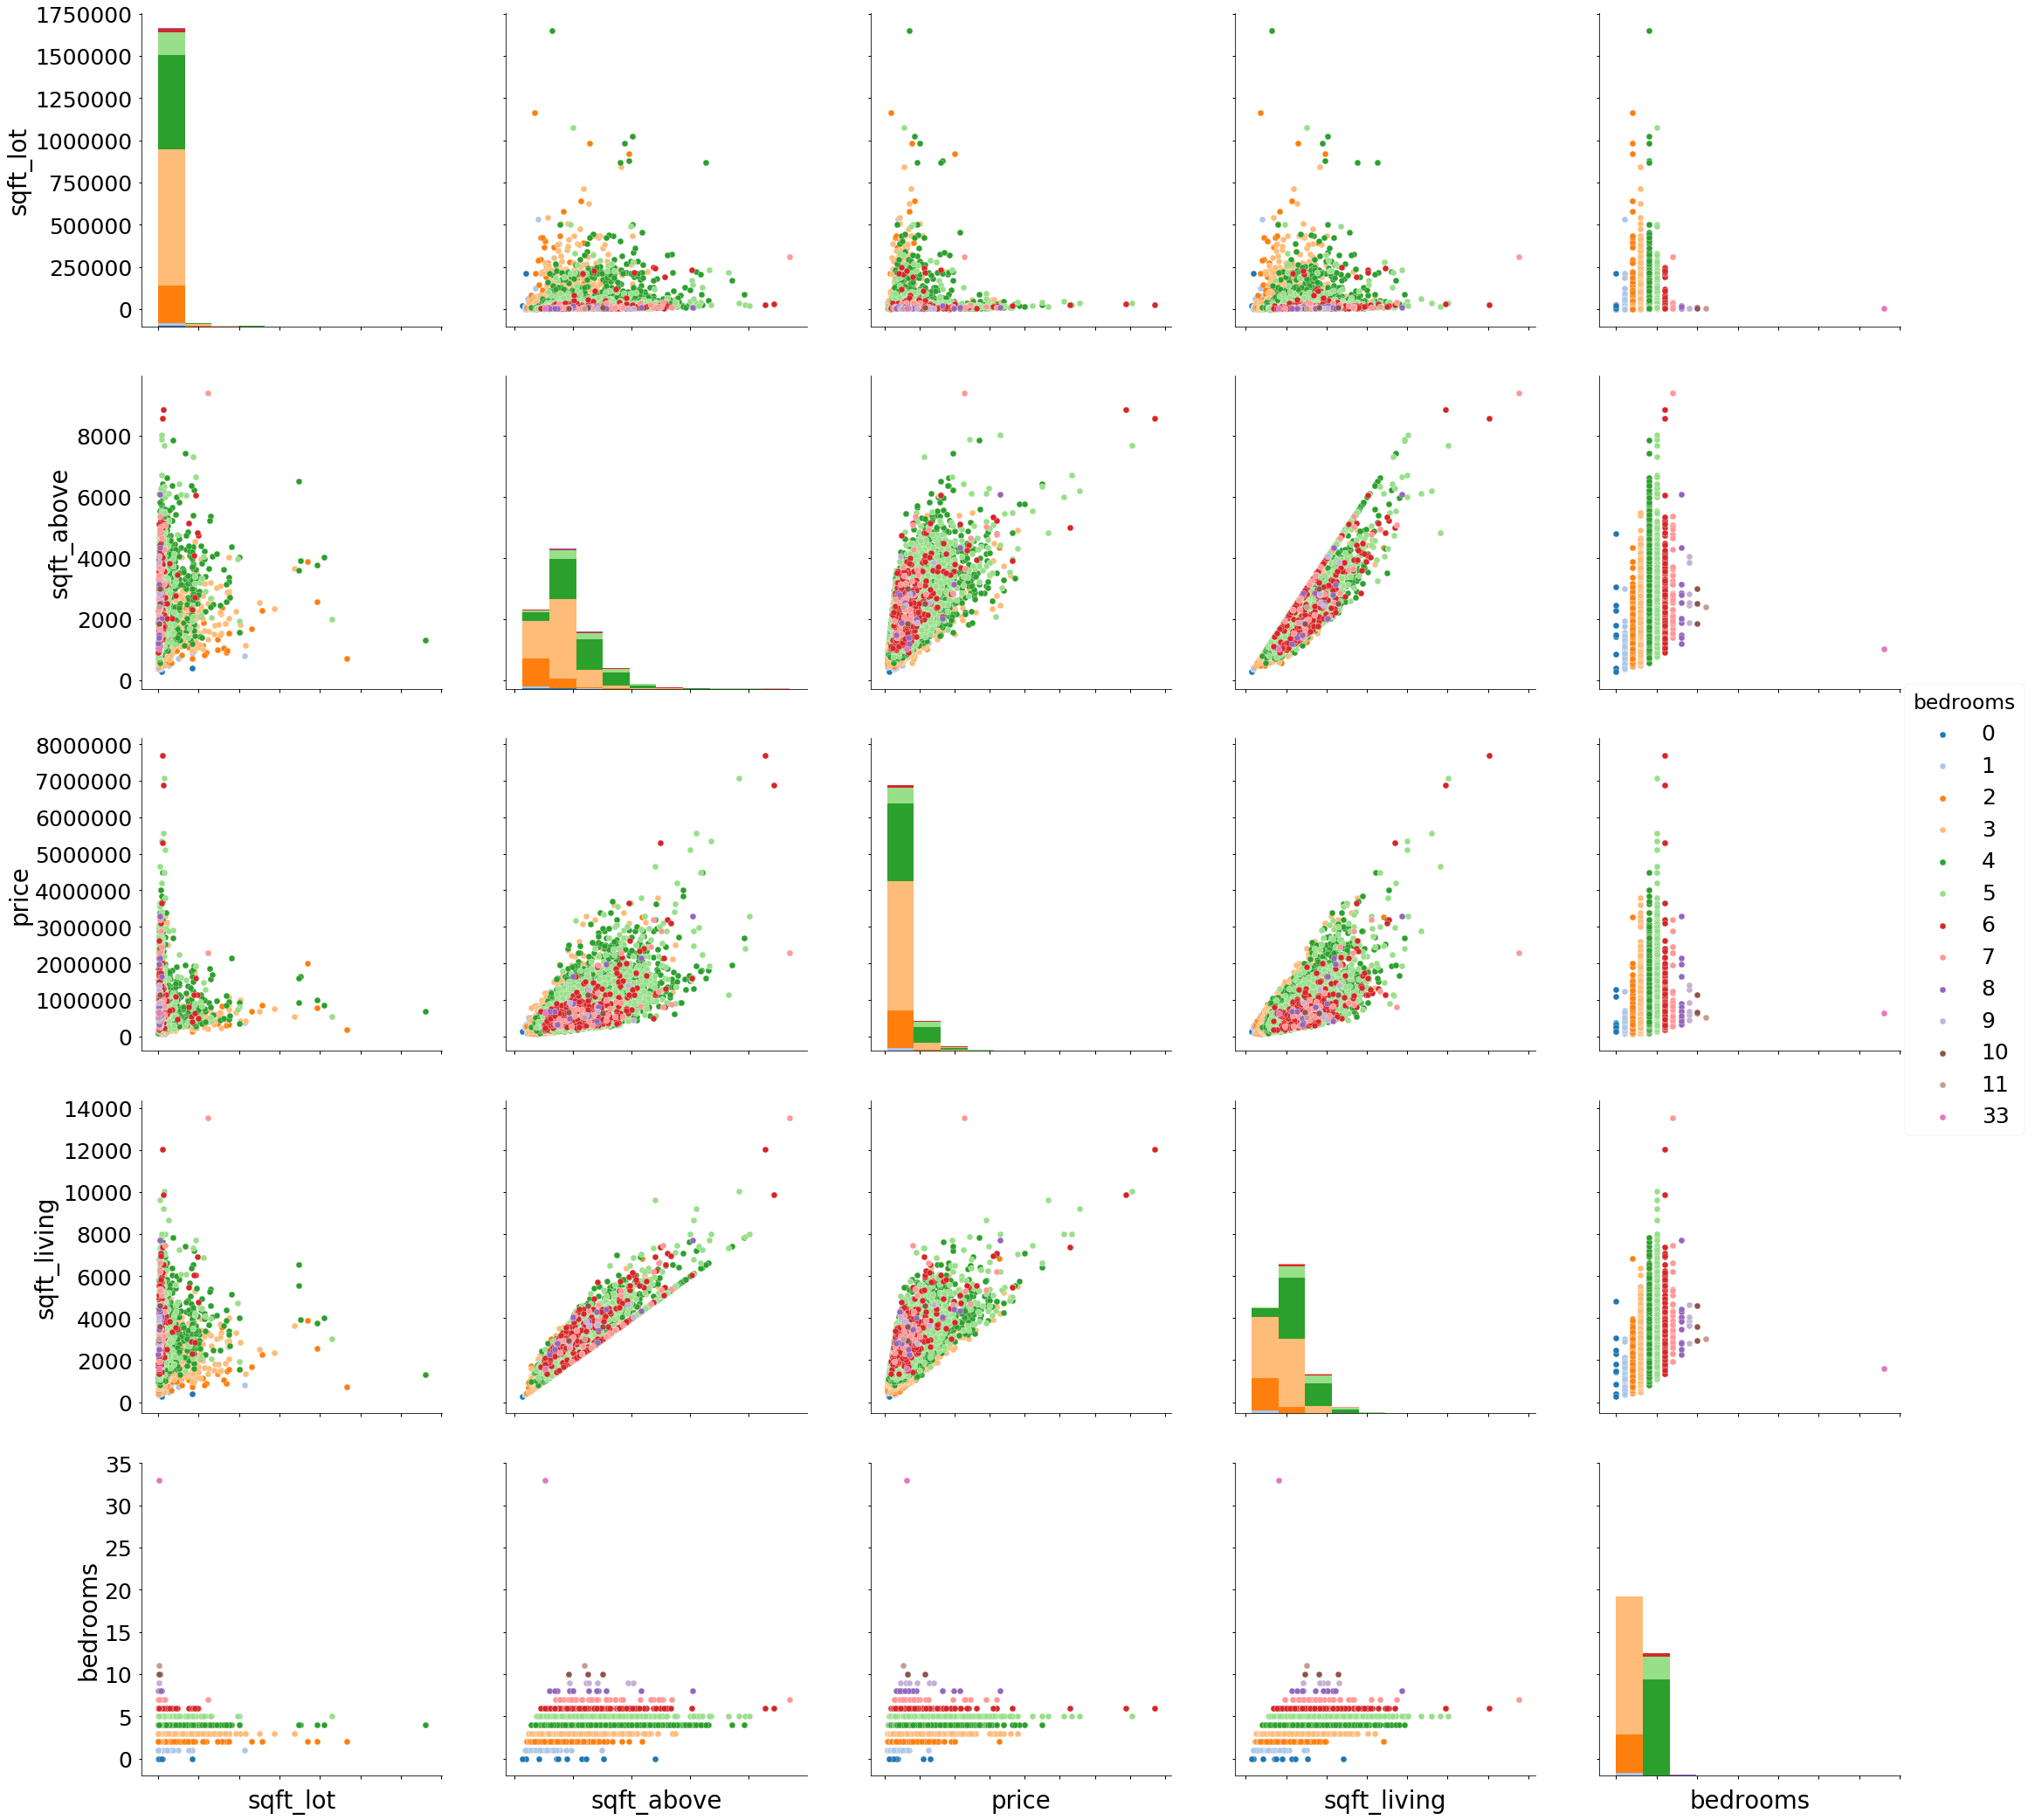

In [32]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=6)
g.set(xticklabels=[]);

Linearity seems to be generally satisfied, e.g. looking at the marginal distributions of **price** vs. **sqft_living**.

### Correlations between Features

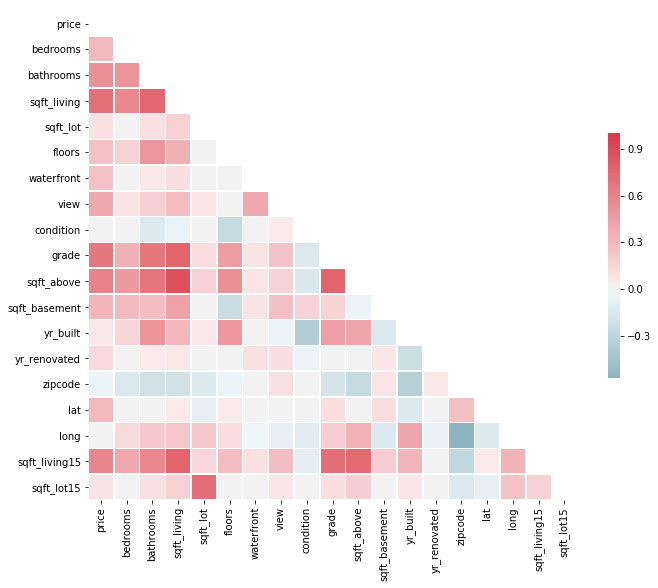

In [33]:
corr = house.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

- Features positively correlated with a large number of other features are **grade**, **sqft_above** and **sqft_living 15**.
- Feature negatively correlated with a large number of other features is **zipode**

## 3.2 - Model Fitting and Prediction Performances

### Split into Training set and Test set 

In [34]:
df_train, df_test = train_test_split(house, test_size=0.20,random_state=42)
df_train = df_train[list(house.columns)]
df_test = df_test[list(house.columns)]

In [35]:
X_train, y_train = df_train.drop('price',axis=1), df_train['price']
X_test, y_test = df_test.drop('price',axis=1), df_test['price']

In [36]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((17290, 18), (17290,), (4323, 18), (4323,))

### Model Fitting

In [37]:
rf_reg = RandomForestRegressor(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

### Prediction Performances

In [38]:
def predictions (rf,X_test,y_test):
    # Make predictions on test data
    predictions = rf.predict(X_test)
    # Performance metrics
    errors = abs(predictions - y_test)
    print('Metrics for Random Forest Regressor')
    print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_test))
    # Compare to baseline
    baseline_mape=np.mean(y_test)
    improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
    print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
    # Calculate and display accuracy
    accuracy = 100 - mape
    print('Accuracy:', round(accuracy, 2), '%.')
    print('R2 score:',r2_score(predictions,y_test))

In [39]:
predictions(rf_reg,X_test,y_test)

Metrics for Random Forest Regressor
Average absolute error: 74276.8 degrees.
Improvement over baseline: 100.0 %.
Accuracy: 86.65 %.
R2 score: 0.829745958294


## 2.3 - Feature Importance

### Gini Importance

The attribute **`feature_importances_`** used here for Gini Importance is already implemented in scikit-learn.

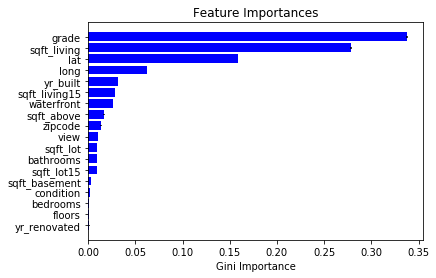

In [40]:
features = np.array(X_train.columns)
imps_gini=rf_reg.feature_importances_
std_gini = np.std([tree.feature_importances_ for tree in rf_reg.estimators_],
             axis=0)
indices_gini = np.argsort(imps_gini)

plt.title('Feature Importances')
plt.barh(range(len(indices_gini)), imps_gini[indices_gini], yerr=std_gini[indices_gini],color='b', align='center')
plt.yticks(range(len(indices_gini)), features[indices_gini])
plt.xlabel('Gini Importance')
plt.show()

### Permutation Importance

The function **`permutation_importances`** used here for Permutation Importance was defined above.

In [41]:
np.random.seed(10)
imps_perm, std_perm = permutation_importances(rf_reg, X_train, y_train,oob_regression_r2_score)

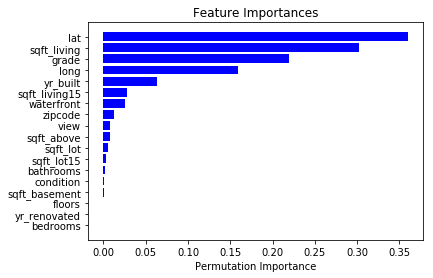

In [42]:
features = np.array(X_train.columns)
indices_perm = np.argsort(imps_perm)

plt.title('Feature Importances')
plt.barh(range(len(indices_perm)), imps_perm[indices_perm], yerr=std_perm[indices_perm],color='b', align='center')
plt.yticks(range(len(indices_perm)), features[indices_perm])
plt.xlabel('Permutation Importance')
plt.show()

The Permutation Importance method, compared to the Gini Importance method:
- Increase the rank of importance of **lat**
- Decreases the rank of importance of **bedrooms**.  

### Boruta

The function **`BorutaPy`** used here for Boruta was describe above and is part of the **`boruta_py`** Github repository.

In [43]:
forest_reg = RandomForestRegressor(min_samples_leaf=5,
                                n_jobs=-1,
                                oob_score=True,
                                random_state=42)
feat_selector_reg = boruta_py.BorutaPy(forest_reg, verbose=2,max_iter=100)

In [44]:
np.random.seed(10)

import time

start = time.time()

feat_selector_reg.fit(X_train.values, y_train.values)

end = time.time()

print(end - start)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	5
349.0632450580597


After fitting BorutaPy, it provides the user with **ranking of features**.
- Confirmed ones are 1
- Tentatives are 2
- Rejected are ranked starting from 3, based on their feature importance history through the iterations.

In [45]:
print('Confirmed: \n',list(np.array(X_train.columns)[feat_selector_reg.ranking_==1]))
print('\nTentatives: \n',list(np.array(X_train.columns)[feat_selector_reg.ranking_==2]))
print('\nRejected: \n',list(np.array(X_train.columns)[feat_selector_reg.ranking_>=3]))

Confirmed: 
 ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'grade', 'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Tentatives: 
 ['sqft_basement']

Rejected: 
 ['bedrooms', 'floors', 'condition', 'yr_renovated']


Some remarks:
- The Boruta procedure takes around 6 minutes to reach 9 iterations.
- At the end of the 9 iterations variables **bedrooms** **floors** **condition** and **yr_renovated** are rejected.
- Variable **sqft_basement** is still in Tentatives.

## 3.4 - Feature Selection and Prediction Performances

### Feature Selection based on Gini Importance 

Variables with a **Gini Importance score lower than a treshold (e.g. 0.05)** are excluded from the new Random Forest model, i.e. all variables except **grade**, **sqft_living**, **lat** and **long**. 

In [46]:
X_train_gini_reg=X_train[['grade','sqft_living','lat','long']]
X_test_gini_reg=X_test[['grade','sqft_living','lat','long']]

In [47]:
rf_gini_reg = RandomForestRegressor(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_gini_reg.fit(X_train_gini_reg, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

### Feature Selection based on Permutation Importance

Variables with a **Permutation Importance score lower than a treshold (e.g. 0.003)** are excluded from the new Random Forest model, i.e. variables **bedrooms**, **yr_renovated**, **floors**, **sqft_basement**, **condition** and **bathrooms**. 

In [48]:
X_train_perm_reg=X_train.drop(['bedrooms','yr_renovated','floors','sqft_basement','condition','bathrooms'],axis=1)
X_test_perm_reg=X_test.drop(['bedrooms','yr_renovated','floors','sqft_basement','condition','bathrooms'],axis=1)

In [50]:
rf_perm_reg = RandomForestRegressor(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_perm_reg.fit(X_train_perm_reg, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

### Feature Selection based on Boruta

Variables that have been **rejected** in the Boruta Importance procedure are excluded from the new Random Forest model, i.e. variables **bedrooms**, **floors**, **condition**, **yr_renovated**.

In [51]:
X_train_boruta_reg=X_train.drop(['bedrooms','floors','condition','yr_renovated'],axis=1)
X_test_boruta_reg=X_test.drop(['bedrooms','floors','condition','yr_renovated'],axis=1)

In [52]:
rf_boruta_reg = RandomForestRegressor(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True,
                            random_state=42)
rf_boruta_reg.fit(X_train_boruta_reg, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

### Prediction Performances

In [53]:
print('******************* Original Model ***********************')
print('\n')
predictions(rf_reg,X_test,y_test)

print ('\n')

print('**** Feature selection based on Gini Importance ****')
print('\n')
predictions(rf_gini_reg,X_test_gini_reg,y_test)

print ('\n')

print('**** Feature selection based on Permutation Importance *****')
print('\n')
predictions(rf_perm_reg,X_test_perm_reg,y_test)

print ('\n')

print('*********** Feature selection based on Boruta **************')
print('\n')
predictions(rf_boruta_reg,X_test_boruta_reg,y_test)

******************* Original Model ***********************


Metrics for Random Forest Regressor
Average absolute error: 74276.8 degrees.
Improvement over baseline: 100.0 %.
Accuracy: 86.65 %.
R2 score: 0.829745958294


**** Feature selection based on Gini Importance ****


Metrics for Random Forest Regressor
Average absolute error: 81406.34 degrees.
Improvement over baseline: 100.0 %.
Accuracy: 85.55 %.
R2 score: 0.797867575241


**** Feature selection based on Permutation Importance *****


Metrics for Random Forest Regressor
Average absolute error: 74307.97 degrees.
Improvement over baseline: 100.0 %.
Accuracy: 86.58 %.
R2 score: 0.836568980378


*********** Feature selection based on Boruta **************


Metrics for Random Forest Regressor
Average absolute error: 74714.05 degrees.
Improvement over baseline: 100.0 %.
Accuracy: 86.56 %.
R2 score: 0.829193752861


Some remarks:
- **Permuation Importance feature selection** provides the **best model** in terms of $R^2$ score.
- The **accuracy** is lower only in the Gini Importance model and similar in all the others.
- It should be noted that the **Boruta** model has high performances, after **removing only 4 features**.

# 4 - Conclusions

The analysis of the two datasets shows that **Permuation Importance** feature selection gets **overall better results**, not only in the prediction performances, but also in the number of features removed.

In both datasets this method provided results similar to the **Gini Importance**, but with some differences in the features' **rank of importance**:
- on one hand, Permutation Importance removed features which were then prooved to be decisive to ensure an improvement of the quality of the prediction, e.g. chlorides in the wine dataset.
- on the other hand, Permutation Importance kept some features (i.e. ranked them higher) that eventually the Gini Importance method discarded, e.g. free sulfure dioxide in the wine dataset.

Finally, the **Boruta** algorithm, despite its computational cost, provided good results in the house dataset by **removing only 4 of the 6 features** discarded by the Permutation Importance method.